# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* [Utilities](Data-Processing.ipynb)
* [Extract layout features and visual tokens](Data-Extraction-2.ipynb)
* [Generate training data](Data-Extraction-3.ipynb)
* Model architecture
    * Visual encoder, generative and discriminative heads
    * [Unsupervised and semi-supervise pretraining](Model-Pretraining.ipynb)
    * [Supervised multi-task training](Model-Training.ipynb)
* [Traversal strategies](Traversal-Layout.ipynb)
* [Reader Agent](Agent-LM.ipynb)
* [Leverage synthetic training data](Data-Gen.ipynb)
* [Optimization for production](Optimization.ipynb)


###  Visual backbone
The task of character recognition with a static set of few classes could be handled by a single `dense` layer in the most minimalistic setup, or by a couple of `convolutional` layers (MNIST). We've got an unbounded number of classes (printed and hand-written), continuous space of layouts, and complex taxonomy. We could use a pre-trained visual foundation model. However, `doc-views` constitute a very distinct and narrow subspace, which could be handled by gray-scale. As we building all from scratch, let's experiment -- let's go with a minimal `ResNet` type of encoder for our visual backbone in a VAE setup due to some generative capability would be needed.

![VAE](assets/vae.svg)

Requirement for a reliable reading of random alpha-numeric codes suggests a character-level focus (we cannot rely on the context statistics). However, some printed characters cannot be recognized without any context: `I, l, 1` in `Arial` look the same, leave alone orientation `6, 9`. Then, let's build an ensemble model with all above as the sub-tasks:
we take a single visual encoder with three separate variational projections serving three different decoders for the three different tasks and resolutions. We may add [`semantics`](#semantic) to serve some prior and / or common-sense along.

In [1]:
import json
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

In [2]:
from scripts.training import *

In [3]:
torch.cuda.empty_cache()
print('GPU' if DEVICE == 'cuda' else 'no GPU')

GPU


### Dataset
The input has three images, all are centered at the same spot in the doc-page view with slightly different resolution: 1.) close focus on a single target char, 2.) target char with some partial context in the view, 3.) target char with left and right neighbor chars completely visible. Input images may have some distortion, added noise, random inverse and orientation.

The three corresponding targets are all with intended black background, clear of noise: 1.) straighten up version of the target char, 2.) context removed, 3.) the target char removed. Lets call them `concept`, `target`, and `context`.

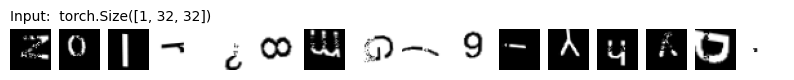

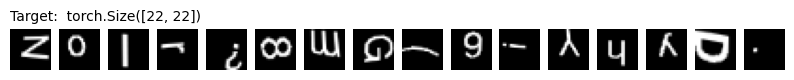

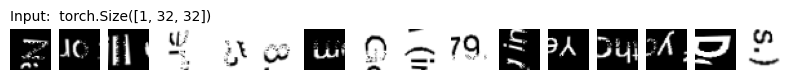

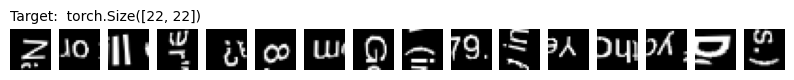

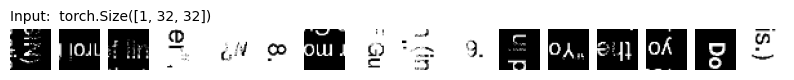

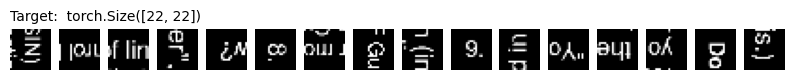

tensor([1, 2, 0, 1, 2, 1, 2, 1, 1, 0, 3, 2, 2, 2, 1, 1])


In [4]:
source = np.random.choice(testset)

# pick the batch for evaluation
for X, Y, labels in DataLoader(PretrainingDataset(source, INDEX, transform=1.), batch_size=16, shuffle=True):
    for i in range(len(X)):
        show_inputs(X[i])
        show_targets(Y[i])
    break
print(labels[-1])

### Model
All the variational projections could be aligned by attaching MLP to $Z$ (embedding). They will vote to produce final classification.

The might be another output constructed by feeding `target` decoder output into `concept` as an input and aligning those as well.

In [5]:
def get_classifier(latent_dim, num_classes):
    hidden_dim = max(latent_dim, num_classes)
    return nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                         nn.ReLU(),
                         nn.InstanceNorm1d(hidden_dim), # small batch
                         nn.Linear(max(latent_dim, num_classes), num_classes))


In [6]:
class MultiVAE(nn.Module):
    """
    Use the same visual backbone encoder with multiple conjoined VAE models
    """
    tags = ['concept','target','context']
    
    def __init__(self, encoder: nn.Module, latent_dim: int,
                       num_classes: int = None, semantic: nn.Module = None,
                       align: bool = None, neighbors: bool = None):
        super().__init__()
        keys = []
        # models
        for tag in self.tags:
            mlp = None if num_classes is None else get_classifier(latent_dim, num_classes)
            vae = VAE(encoder, get_decoder(), latent_dim, mlp=mlp)
            setattr(self, tag, vae)
            keys += [f'{tag}-{key}' for key in vae.keys]                    
        # consensus classifier(s)
        self.semantic = semantic
        if not semantic is None:
            keys += ['semantic']
        # discriminator loop
        if align:
            keys += ['align']
        # context: try to classify neighbors
        if num_classes and neighbors:
            self.neighbors = nn.ModuleList([get_classifier(latent_dim, num_classes) for _ in ['left','right']])
            keys += ['left','right']
        else:
            self.neighbors = None              
        # list all outputs
        self.keys = keys
        
    def forward(self, X):
        outputs, z = [], []
        for i, tag in enumerate(self.tags):
            out = getattr(self, tag)(X[i])
            outputs += list(out)
            z.append(out[1])
        if 'semantic' in self.keys:
            outputs.append(self.semantic(outputs))
        if 'align' in self.keys:
            outputs.append(self.concept.decoder(z[self.tags.index('target')])[0])
        if self.neighbors is not None:
            outputs += [side(z[self.tags.index('context')]) for side in self.neighbors]
        return outputs
    

In [7]:
latent_dim = 64

encoder = get_encoder()
model = MultiVAE(encoder, latent_dim).to(DEVICE)

for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label NaN
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label NaN
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label NaN


In [8]:
num_classes = len(INDEX)

model = MultiVAE(encoder, latent_dim, num_classes).to(DEVICE)

for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 156])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 156])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 156])


In [9]:
model = MultiVAE(encoder, latent_dim, num_classes, neighbors=True).to(DEVICE)

for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 156])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 156])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 156])
left torch.Size([16, 156])
right torch.Size([16, 156])


<a name="semantic"></a>

### Add `semantics`
The ability to classify context would be useful: orientation `[0, 90, 180, 270]` and position type like word-head / tail / mid, or stand alone. That could be done in many ways.

In [10]:
class OrientationConsensus(nn.Module):
    """
    Classify collective opinion of all components on the matter
    """
    def __init__(self, keys: list, latent_dim: int, semantic_dim: int):
        super().__init__()
        self.keys = keys
        self.semantic = get_classifier(latent_dim * 3, semantic_dim)
        
    def forward(self, outputs):
        context = torch.cat([outputs[self.keys.index(f'{x}-z')] for x in ['concept','target','context']], axis=1)
        return self.semantic(context)
    

In [11]:
semantic_dim = 4

semantic = OrientationConsensus(model.keys, latent_dim, semantic_dim)
model = MultiVAE(encoder, latent_dim, num_classes, semantic=semantic).to(DEVICE)

for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 156])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 156])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 156])
semantic torch.Size([16, 4])


In [12]:
class ContextClassifier(nn.Module):
    """
    Classify based on selective opinion 
    """
    def __init__(self, keys: list, latent_dim: int, semantic_dim: int):
        super().__init__()
        self.keys = keys
        self.semantic = get_classifier(latent_dim, semantic_dim)
        
    def forward(self, outputs):
        context = outputs[self.keys.index('context-z')]
        return self.semantic(context)
    

In [13]:
semantic_dim = 4

semantic = ContextClassifier(model.keys, latent_dim, semantic_dim)
model = MultiVAE(encoder, latent_dim, num_classes, semantic=semantic).to(DEVICE)

for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 156])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 156])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 156])
semantic torch.Size([16, 4])


In [14]:
# full-stack
model = MultiVAE(encoder, latent_dim, num_classes, semantic=semantic, neighbors=True).to(DEVICE)

for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 156])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 156])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 156])
semantic torch.Size([16, 4])
left torch.Size([16, 156])
right torch.Size([16, 156])
